# Agrupar 

Agruparemos utilizando 2 enfoques:

- Por subtítulos
- Por videos 

Para analizar de una manera más detallada el corpus

In [1]:
#Para el corpus
import sys
sys.path.append('..')
from src.data import Data 
#Para calcular TF-IDF
from src.tfidf import TFIDF
#Para graficar palabras
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm 
from collections import defaultdict
import numpy as np
# nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords #Listas de stopwords

[nltk_data] Downloading package punkt to /home/karla/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/karla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/karla/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/karla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/karla/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/karla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Vectores TF-IDF

### Gráficamos los vectores de TF-IDF de cada subtítulo 

In [2]:
#Cargamos el corpus limpio
videos = Data("../pkl/clean_videos.pkl")
videos.get_all_subtitles()
#Creamos el objeto tfidf
tfidf_objxO = TFIDF(videos)
# Cargamos los valores tfidf previamente calculados
tfidf_objxO.tfidf = "../pkl/tfidfxOracion.pkl" #Vectores por texto
# Obtenemos los vectores por subtítulo
tfidf_objxO.get_tfid_vectors(document=False)

100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Tomamos 2 palabras clave por subtítulo ya que la mayoría de los subtítulos no son muy largos (el más largo es de 56, pero hay muchos subtítulos de 1 palabra)

In [18]:
more = ["si", "bien", "ahora", "así", "aquí", "pues"]
stopwords_list = stopwords.words('spanish') + more

def get_2key_word(sentence):
    """
    Dada una cadena y su valor tf_idf
    Nos quedamos con las 2 primeras palabras que no sean stopwords
    para que representen al subtítulo
    """
    word = ""
    val = []
    sentence.sort(key = lambda x: x[1])
    j = 0
    if len(sentence) == 1: #Si únicamente hay una palabra
        #Hacemos padding para que el vector siempre tenga 2 entradas
        word = sentence[0][0]
        val = [sentence[0][1], 0]
    else:
        for  w, i in sentence:
            if j < 2 and w not in stopwords_list: 
                word += w + " "
                val.append(i)
                j += 1
    return word, val

In [21]:
def do_padding(vector, t):
    '''
    Agrega 0 al vector si no es del tamaño t 
    Args:
        vector (lst): lista de tamaño diferente
        t (int): Tamaño esperado del vector
    '''
    for _ in range(0, t - len(vector)):
        vector.append(0)

In [25]:
def get_vectors():
    '''
    Regresa un diccionario con los subtítulos y su vector tfidf
    '''
    vectors = {}
    #Iteramos sobre los canales
    for chanel in tqdm(tfidf_objxO.data.corpus):
        for video in chanel:
            #Cada texto se guarda por oraciones
            if 'subtitles' in video:
                for s in video['subtitles']:
                    sentence = list(zip(s["text"], s["tfid"]))
                    #Ordenamos los valores tf-idf
                    sentence.sort(key = lambda x: x[1])
                    #Obtenemos 1 o 2 palabras clave
                    word, val = get_2key_word(sentence)
                    #Hacemos padding para que el vector siempre tenga 2 entradas
                    do_padding(val, 2)
                    vectors[word] = val
    return vectors

In [5]:
#Función para plotear en dos dimensiones con etiquetas
def plot_words(X,ids, color='blue'):
    '''
    Gráfica las oraciones dado su vector tfid

    Args:
        X (list): coordenadas del vector aplicando PCA
        ids (list): oraciones
    '''
    r=0
    plt.scatter(X[:,0],X[:,1], marker='o', c=color)
    for label,x,y in tqdm(zip(ids, X[:,0], X[:,1])):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1

In [24]:
mds_model = PCA(n_components=2)
vectors = get_vectors()
X_pca = mds_model.fit_transform(list(vectors.values()))

100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


In [26]:
print(list(vectors.items())[100:115])

[('rescatadores vuelta ', [27.065197858734255, 2484.8587661610527]), ('metiendo éstos ', [282.80852337710803, 521.5830229150212]), ('invocas permitir ', [27.065197858734255, 1041.0958627370796]), ('revés ojos ', [299.7330332994848, 39142.70012012738]), ('raros', [318.46288535642265, 0]), ('super ello ', [1837.2216920524, 5010.494656017035]), ('increíble ', [3120.107949989873, 0]), ('alvin gustaron ', [27.065197858734255, 86.46845429347844]), ('ardillas', [79.3677011885693, 0]), ('monstruos', [465.6578681656081, 0]), ('profesionales ver ', [928.158714730899, 22988.94172971779]), ('metemos choca ', [154.5761400148225, 200.8023572942111]), ('lata ', [470.62071136727934, 0]), ('guinness libro ', [79.3677011885693, 2634.933181115102]), ('perdimos ', [206.42359959792924, 0])]


Con 10 subtítulos

10it [00:00, 3022.70it/s]


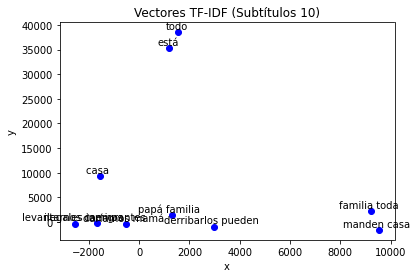

In [27]:
#Solo se gráfican algunas oraciones
plot_words(X_pca[20:30], list(vectors.keys())[20:30])
plt.title('Vectores TF-IDF (Subtítulos 10)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Con todos los subtítulos

10it [00:00, 5300.52it/s]


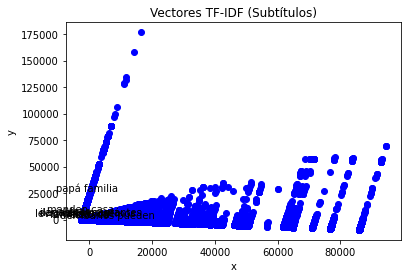

In [28]:
plot_words(X_pca, list(vectors.keys())[20:30])
plt.title('Vectores TF-IDF (Subtítulos)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Gráficamos los vectores de TF-IDF de cada vídeo 

In [29]:
#Cargamos el corpus limpio
videos = Data("../pkl/clean_videos.pkl")
videos.get_all_subtitles()
#Creamos el objeto tfidf
tfidf_obj = TFIDF(videos)
# Cargamos los valores tfidf previamente calculados
tfidf_obj.tfidf = "../pkl/tfidf.pkl" #Vectores por texto

100%|██████████| 9/9 [00:00<00:00, 18.62it/s]


Para generar los vectores tomaremos únicamente las 10 palabras más representativas de cada vídeo

In [33]:
def get_vectors_video():
    '''
    Regresa un diccionario con los subtítulos y su vector tfidf
    '''
    vectors = {}
    #Iteramos sobre los canales
    for id in tqdm(tfidf_obj.tfidf):
        v = sorted(tfidf_obj.tfidf[id].values(), reverse=True)[:10]
        do_padding(v,10)
        vectors[id] = v
    return vectors

In [36]:
vectors_video = get_vectors_video()
val_pca = mds_model.fit_transform(list(vectors_video.values()))

100%|██████████| 3276/3276 [00:00<00:00, 6614.11it/s]


Con 10 videos

10it [00:00, 8305.55it/s]


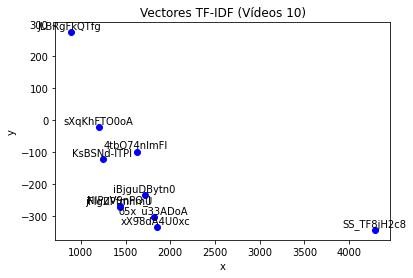

In [37]:
#Solo se gráfican algunos vídeos
plot_words(val_pca[50:60], list(tfidf_obj.tfidf.keys())[50:60])
plt.title('Vectores TF-IDF (Vídeos 10)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Con todos los videos

1it [00:00, 2186.81it/s]


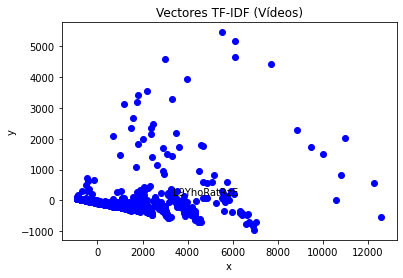

In [38]:
#Solo se gráfican vídeos
plot_words(val_pca, list(tfidf_obj.tfidf.keys())[:1])
plt.title('Vectores TF-IDF (Vídeos)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## K-means

In [39]:
class kMeans():
    def __init__(self, n_clusters=2):
        #Número de clústers
        self.n_clusters = n_clusters
        #Clústers vectores
        self.clusters = defaultdict(list)
        #Clústers con nombres
        self.named_clusters = defaultdict(list)
        #Centroides 
        self.centroids = None

    def fit(self, X, names=None):
        #Inicialización de parámetros
        C = X[np.random.choice(X.shape[1], self.n_clusters)]
        #Paro
        stop = False
        while stop == False:
            #Cálculo de distancias con respecto a c
            dists = np.array([np.linalg.norm(X-c, axis=1) for c in C])
            #Cluster más cercano
            clusts = np.argmin(dists, axis=0)
            #Clusterización de los datos
            if names != None:
                data = names
            else:
                data = [i for i in range(X.shape[0])]
            for k, v, n in zip(clusts, X, data):
                self.clusters[k].append(v)
                self.named_clusters[k].append(n)
            
            #Actualización de C
            new_c = np.array([sum(vecs)/len(vecs) for clas, vecs in self.clusters.items()])

            #Criterio de paro
            if C.all() == new_c.all():
                stop = True
                self.centroids = C
            else:
                #Actualización de parámetros
                C = new_c

Probamos con los vectores TFIDF por subtítulo

In [40]:
modelxO = kMeans(5)
modelxO.fit(X_pca, list(vectors.keys()))
modelxO.named_clusters

defaultdict(list,
            {0: ['accidente papá ',
              'necesito pasó ',
              'lograríamos nunca ',
              'noche especial ',
              'campo familia ',
              'sabíamos juntos ',
              'basketball entrar ',
              'jugar podemos ',
              'rafa habla ',
              'daríamos mamá ',
              'papá familia ',
              'familia toda ',
              'ilegales inmigrantes ',
              'manden casa ',
              'derribarlos pueden ',
              'encantaría aprender ',
              'intentar nuevo ',
              'aventura cosa ',
              'aventura toda ',
              'aventura vida ',
              'llevan pasando ',
              'vecina hola ',
              'hermano hacemos ',
              'necesitamos música ',
              'perfecta chica ',
              'película quieres ',
              'escribes canciones ',
              'gustan solo ',
              'crear vas ',
              'emp

In [43]:
for c, docs in modelxO.named_clusters.items():
    print(c, len(docs)) #Creo que vamos a tener que cambiar de vectores

0 246758
1 191014


Probamos con los vectores TFIDF por video

In [41]:
model = kMeans(5)
model.fit(val_pca, list(tfidf_obj.tfidf.keys()))
model.named_clusters

defaultdict(list,
            {0: ['L9YhoRatRzE',
              'Zx9kaA-kMAs',
              'V3kG7MkMAfw',
              '1Hr-g3rtx_E',
              'apnFJ7XUKxc',
              'QyHk__WwcG4',
              'f3RU2Yg_7xc',
              'zpoHEuYOGDk',
              'n_KeE0esRV4',
              'x2d_d5fQXmc',
              '7YAEQ7LYCfs',
              'Kocd0_-Q3t4',
              '3TAiv5AJ2Os',
              'RIfLtyz5mJE',
              'Hc6KTczslg8',
              'rCZZzjlrEm4',
              'BD9Spf1zjks',
              '1yOZTLwIe1I',
              'yHcLu8b9EgQ',
              'Ay2zwt7A8Io',
              'KApKXV9HFDM',
              'erwbm--c3o4',
              'N79hck79Rbk',
              '774PAnJAhks',
              'AuqGBGgDT5U',
              'I6ZgwsK4COs',
              '8IjRSNEl-oQ',
              'imYkTsz7Xlk',
              '_sCenuYhc08',
              'Ln63_5k3VZo',
              'X-VkQCP4gCA',
              'di8FQDaspd8',
              'UOWnOzQFbqs',
              '-yUpr55

In [42]:
for c, docs in model.named_clusters.items():
    print(c, len(docs)) #Creo que vamos a tener que cambiar de vectores

0 3276


In [ ]:
"""clusters = np.zeros(len(list(tfidf_obj.tfidf.keys())))
for c, docs in model.named_clusters.items():
    for d in docs:
        clusters[tfidf_obj.tfidf[d]] = c
        
Para que la grágica funcione bien necesitaríamos saber las categorías, se me ocurre 
que analizar las palabra clave y de ahí sacar los temas, verlo desde el punto de vista de los 
canales"""
#plot_words(val_pca, list(tfidf_obj.tfidf.keys()))